In this notebook, study on tensile strength of the FDM fabricated component is taken as major factor. This is because when FDM fabricated component achieves desire strength it would meet application requirment.

The content of this notebook follows:
* Data Loading
* EDA 
* Visualization
* Feature importance
* Modelling

# **Data Loading**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data=pd.read_csv('../input/3dprinter/data.csv')
data.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,5,0.7


In [3]:
data.shape

(50, 12)

In [4]:
data.isnull().any()

layer_height          False
wall_thickness        False
infill_density        False
infill_pattern        False
nozzle_temperature    False
bed_temperature       False
print_speed           False
material              False
fan_speed             False
roughness             False
tension_strenght      False
elongation            False
dtype: bool

# **EDA**

In [5]:
data.select_dtypes(include='object').head()

,infill_pattern,material
0,grid,abs
1,honeycomb,abs
2,grid,abs
3,honeycomb,abs
4,grid,abs


In [6]:
data['infill_pattern'].value_counts()

grid         25
honeycomb    25
Name: infill_pattern, dtype: int64

In [7]:
data['material'].value_counts()

abs    25
pla    25
Name: material, dtype: int64

In [8]:
data_1=pd.get_dummies(data)

In [9]:
data_1.head()

,layer_height,wall_thickness,infill_density,nozzle_temperature,bed_temperature,print_speed,fan_speed,roughness,tension_strenght,elongation,infill_pattern_grid,infill_pattern_honeycomb,material_abs,material_pla
0,0.02,8,90,220,60,40,0,25,18,1.2,1,0,1,0
1,0.02,7,90,225,65,40,25,32,16,1.4,0,1,1,0
2,0.02,1,80,230,70,40,50,40,8,0.8,1,0,1,0
3,0.02,4,70,240,75,40,75,68,10,0.5,0,1,1,0
4,0.02,6,90,250,80,40,100,92,5,0.7,1,0,1,0


# **Visualization**

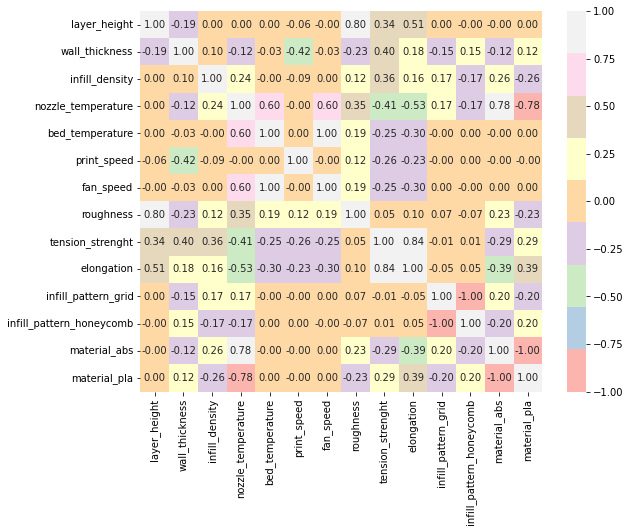

In [10]:
plt.figure(figsize=(9,7))
corr_mat=data_1.corr()
sns.heatmap(corr_mat,annot=True,fmt='.2f',cmap='Pastel1')
plt.show()

In [11]:
x_1=data_1.drop(['tension_strenght'],axis=1)
y_1=data_1['tension_strenght']

In [12]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()

# **Feature importance**

Finding feature importance

In [13]:
from sklearn.ensemble import RandomForestRegressor

In [14]:
rf=RandomForestRegressor()
rf.fit(x_1,y_1)
fi=rf.feature_importances_

In [15]:
fi

array([0.01135654, 0.0969621 , 0.07544932, 0.01644313, 0.00854018,
       0.01251531, 0.00974745, 0.02287496, 0.72695403, 0.00206939,
       0.00478271, 0.00584111, 0.00646377])

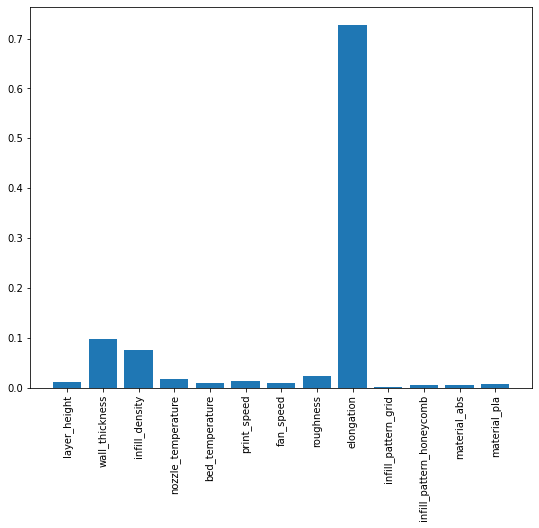

In [16]:
plt.figure(figsize=(9,7))
plt.bar(x_1.columns,fi)
plt.xticks(rotation=90)
plt.show()

The tensile strength depends lots on elongation, wall thickness and infill density.

In [17]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [18]:
xtran,xtest,ytran,ytest=train_test_split(x_1,y_1,test_size=0.1,random_state=42)

# **Modelling**

1.With support vector regression

In [19]:
svr=SVR()
params_grid={'C':[0.1,1,10,50,100],
            'gamma':[1,0.1,0.01,0.001],
            'kernel':['rbf']}

In [20]:
grd_svr=GridSearchCV(svr,param_grid=params_grid,scoring='neg_mean_squared_error')

In [21]:
grd_svr.fit(xtran,ytran)

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 50, 100],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
             scoring='neg_mean_squared_error')

In [22]:
grd_svr.best_score_

-76.0120309825792

In [23]:
grd_svr.best_params_

{'C': 50, 'gamma': 0.001, 'kernel': 'rbf'}

In [24]:
svr=SVR(**grd_svr.best_params_)

In [25]:
svr.fit(x_1,y_1)

SVR(C=50, gamma=0.001)

RMSE of SVR

In [26]:
np.sqrt(mean_squared_error(svr.predict(x_1),y_1))

0.09998544232194084

With XGBoost

In [27]:
import xgboost as xgb

In [28]:
para_grd={'n_estimators':[50,100,300,500],
          'max_depth':[2,3,5,7],
          'eval_metric':['rmse']
         }
xg=xgb.XGBRegressor()
grd_xg=GridSearchCV(xg,param_grid=para_grd)

In [29]:
grd_xg.fit(x_1,y_1)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                          

In [30]:
grd_xg.best_params_

{'eval_metric': 'rmse', 'max_depth': 2, 'n_estimators': 100}

In [31]:
grd_xg.best_score_

0.5531456821245933

In [32]:
xg=xgb.XGBRegressor(**grd_xg.best_params_)
xg=xg.fit(x_1,y_1)
np.sqrt(mean_squared_error(xg.predict(x_1),y_1))

0.26186229229931945

**From this above two ML model, support vector regessor performs better than xgbregressor**